# Optimization for Machine Learning

## Bayesian Optimization Algorithm  

In [1]:
%matplotlib inline

import numpy as np
import pylab as plt
import matplotlib.cm as cm
import matplotlib
from PIL import Image as im
import math
import time 
import sklearn

import mdptoolbox
import mdptoolbox.example


import pylab as pb
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

from IPython.display import display
from IPython.display import Image



In [6]:
!pip freeze

absl-py==2.1.0
aeppl==0.0.38
aesara==2.8.7
alabaster==0.7.12
anyio==3.6.2
app-model==0.1.1
appdirs==1.4.4
apt-xapian-index==0.49
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arrow==1.2.2
arviz==0.13.0
asciitree==0.3.3
astroid==2.11.7
astroML==1.0.2.post1
astropy==5.1.1
asttokens==2.0.5
astunparse==1.6.3
atomicwrites==1.4.1
attrs==21.4.0
audioread==3.0.0
Automat==20.2.0
autopep8==1.6.0
Babel==2.10.3
backcall==0.2.0
bcrypt==3.2.0
beautifulsoup4==4.11.1
bidict==0.22.1
binaryornot==0.4.4
biosignalsnotebooks==0.6.13
biosppy==2.1.1
bitalino==1.2.6
black==22.6.0
bleach==5.0.0
blinker==1.4
blis==0.7.7
bokeh==2.4.3
build==0.9.0
cachetools==5.2.0
cachey==0.2.1
catalogue==2.0.7
certifi==2020.6.20
cffi==1.15.0
cftime==1.6.2
chardet==4.0.0
charset-normalizer==2.1.1
click==8.0.3
cloudpickle==2.1.0
colorama==0.4.4
command-not-found==0.3
commonmark==0.9.1
configobj==5.0.6
cons==0.4.5
constantly==15.1.0
contourpy==1.0.5
cookiecutter==2.1.1
coverage==6.5.0
coveralls==3.3.1
crypto


## Kernel definition with GPy

The GPy library allows us to define different types of kernel functions that are used to specify a Gaussian process. A description of the functionalities of GPy can be accessed from https://gpy.readthedocs.io/en/deploy/index.html

### Shapes of the kernel and hyperparameters

In the following example, we define a squared exponential kernel (RBF) and set the lenghscale parameter to different values to visualize the corresponding kernels. Notice that we specify the dimension of the input vectors in  the kernel definition. 

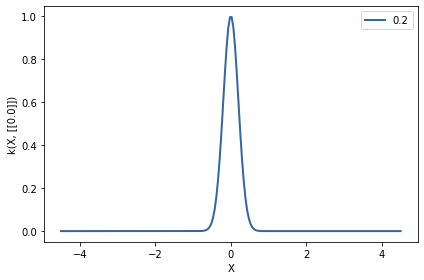

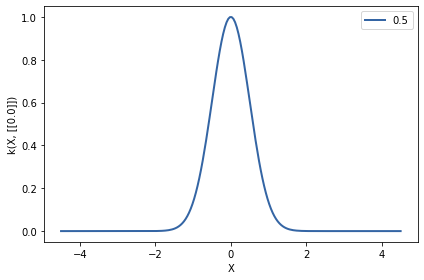

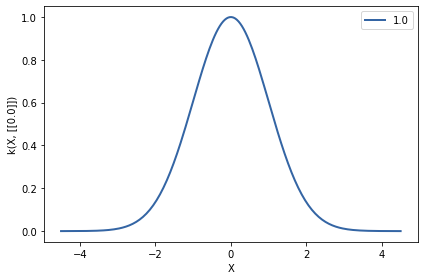

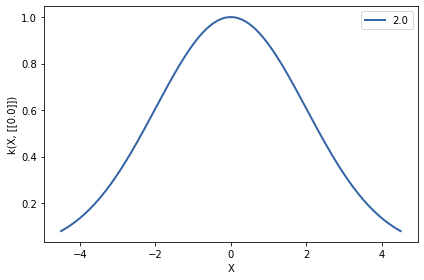

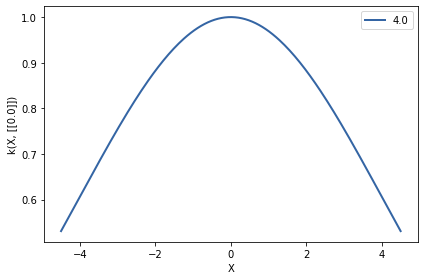

In [2]:
k = GPy.kern.RBF(input_dim=1)
#k = GPy.kern.Matern32(input_dim=1)

theta = np.asarray([0.2,0.5,1.,2.,4.])
for t in theta:
    k['.*lengthscale']=t
    k.plot()
    pb.legend([t])

### Gaussian Process 

A Gaussian process (GP) is a collection of random variables, any finite number of which have a joint Gaussian distribution. In the example below we use the mean function and the covariance function of the Gaussian process to create the joint gaussian distribution and sample points from it. 

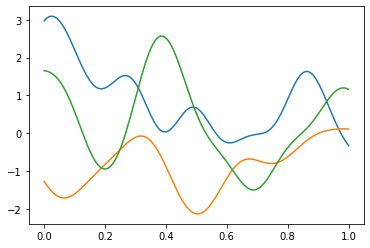

In [3]:
# Number of points (x) sampled for each of the functions
number_points = 500

# Number of samples from the Gaussian process (How many functions)
n_samples = 3

# The kernel function is defined. 
# It is the squared exponential kernel (RBF) defined above
kernel = GPy.kern.RBF(input_dim=1,lengthscale=0.1)

# We set a set of number_points random points between 0 and 1
# These are the x values from which the kernel function is evaluated
# to create the covariance matrix
X = np.linspace(0.,1.,number_points)
X = X[:,None] 

# The mean function of the Gaussian Process is equal zero (m(x)=0)
mu = np.zeros((number_points))

# The covariance matrix is created using the kernel function
# defined above
C = kernel.K(X,X) 

# Since N(mu,C) is a multivariate distribution we can sample 
# n_samples functions from it
Z = np.random.multivariate_normal(mu,C,n_samples)


# We plot the samples. Each curve is a function sampled from the gaussian distribution
pb.figure()
for i in range(n_samples):
 pb.plot(X[:],Z[i,:])

## Exercise  1 

Create a Gaussian Process similar to the previous examples with the following constraints:

 
 - Use the periodic kernel:   per_kernel = GPy.kern.StdPeriodic(1, variance=1.0, lengthscale=0.5, period=0.5)
 - Select points from the interval [0,5]
 - Sample 10 new functions from the Gaussian process
 - Observe the patterns of the functions and compare with the patterns of the previous functions
 

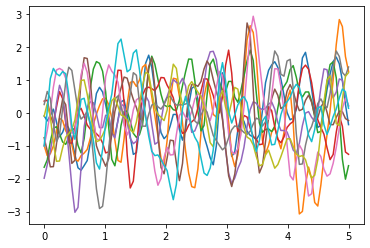

In [4]:
per_kenel = GPy.kern.StdPeriodic(1, variance= 1.0, lengthscale= 0.5, period= 0.5)

number_points = 100
X = np.linspace(0.,5.,number_points)
X = X[:,None]

mu = np.zeros((number_points))
C = kernel.K(X,X) 

number_functions = 10
Z = np.random.multivariate_normal(mu,C, number_functions)

pb.figure()
for i in range(number_functions):
 pb.plot(X[:],Z[i,:])

### Gaussian process regression 

A kernel can be used for defining a Gaussian Process model and doing regression as in the following example n which we use a Gaussian process to fit 10 points. Notice in the visualization of the model, how areas where there are not observations have a higher uncertainty. 

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f98b2235ae0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f98b2236740>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f98b2236860>]}

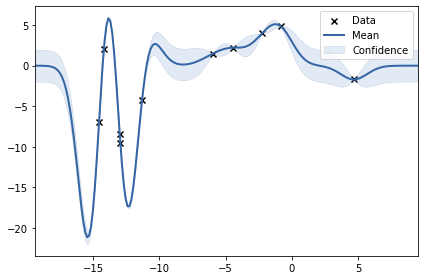

In [5]:
kernel = GPy.kern.RBF(input_dim=1,lengthscale=1)
train_X = np.random.uniform(-15, 5, (10,1))
train_Y = np.random.uniform(-15, 5, (10,1))

# The model is trained
m = GPy.models.GPRegression(train_X,train_Y,kernel,noise_var=0)

# The model is plotted
m.plot()

### Combination of kernels and creation of new kernels

Gpy contains a large number of kernel implementations. It is also possible to implement new kernels that allow to represent a-priori information about a problem (https://gpy.readthedocs.io/en/deploy/tuto_creating_new_kernels.html). 

This functionality is very useful for regression problems.  A catalogue of possible kernel combinations is detailed in the Kernel Cookbook: https://www.cs.toronto.edu/~duvenaud/cookbook/

Below there is a list of possible kernel definitions (and combinations)

        k1 = GPy.kern.RBF(2, variance=1.0, lengthscale=[1.0,1.0], ARD=True)
        k2 = GPy.kern.RatQuad(2, variance=2.0, lengthscale=1.0, power=2.0, active_dims = [0,1])
        k3 = GPy.kern.Bias(2, variance=2.0, active_dims = [1,0])
        k4 = GPy.kern.StdPeriodic(2, variance=2.0, lengthscale=1.0, period=1.0, active_dims = [1,1])
        k5 = GPy.kern.Linear(2, variances=[2.0, 1.0], ARD=True, active_dims = [1,1])
        k6 = GPy.kern.Exponential(2, variance=1., lengthscale=2)
        k7 = GPy.kern.Matern32(2, variance=1.0, lengthscale=[1.0,3.0], ARD=True, active_dims = [1,1])
        k8 = GPy.kern.Matern52(2, variance=2.0, lengthscale=[2.0,1.0], ARD=True, active_dims = [1,0])
        k9 = GPy.kern.ExpQuad(2, variance=3.0, lengthscale=[1.0,2.0], ARD=True, active_dims = [0,1])
        k10 = k1 + k1.copy() + k2 + k3 + k4 + k5 + k6
        k11 = k1 * k2 * k2.copy() * k3 * k4 * k5
        k12 = (k1 + k2) * (k3 + k4 + k5)
        k13 = ((k1 + k2) * k3) + k4 + k5 * k7
        k14 = ((k1 + k2) * k3) + k4 * k5 + k8
        k15 = ((k1 * k2) * k3) + k4 * k5 + k8 + k9



### Effect of adding new information to the regression

In each iteration of Bayesian optimization, we add a new point to the set of train data and recompute the Gaussian model. In the figures below we simulate the effect of adding new points in the shape of the Gaussian Process approximation. 

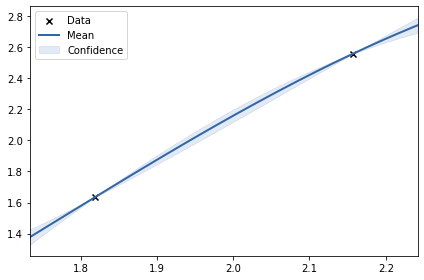

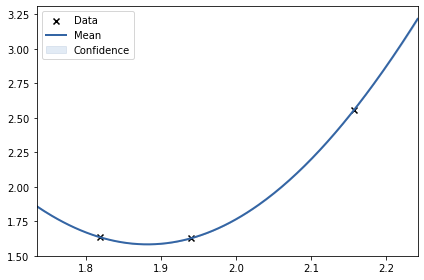

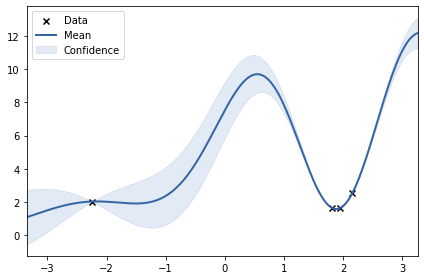

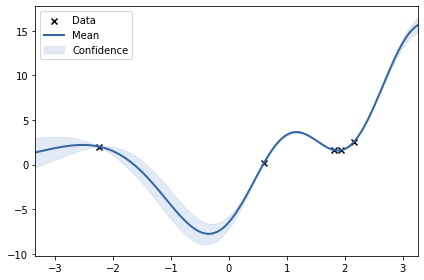

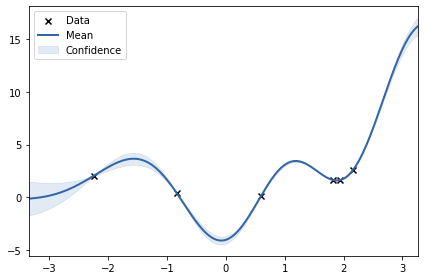

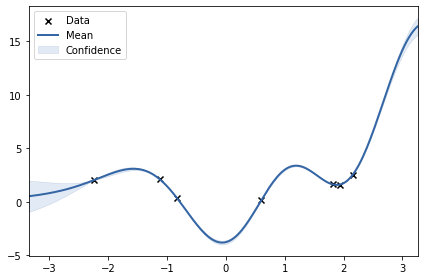

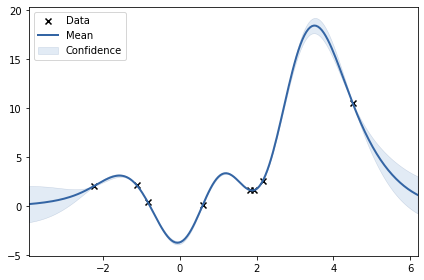

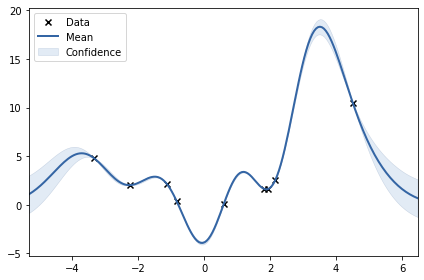

In [7]:
# We generate a random set of 20 points (xi,yi)
X = np.random.uniform(-5, 5, (20,1))
Y = np.array([0.5 * (a*a) + (.75 * np.random.randn()) for a in X])

# Each plot will represent the Gaussian process with k \in (2,10) pointss
for pos in np.arange(2,10):
    kernel = GPy.kern.RBF(input_dim=1)
    m = GPy.models.GPRegression(X[:pos],Y[:pos],kernel,noise_var=0)
    m.plot()

## Bayesian Optimization implementation with GPyOpt

In order to use BO we need to define the function to optimize, the variables and the bounds of the variables

In [8]:
# Function to optimize
def myfunction(x):
    return (np.sin(x)*x**2)

In [9]:
# Bounds of the function
bounds = [{'name': 'x_1', 'type': 'continuous', 'domain': (-2*np.pi,2*np.pi)}]

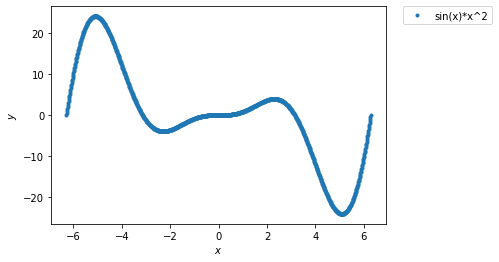

In [10]:
# We visualize the function that is going to be optimized

number_points = 1000
X = np.linspace(-2*np.pi,2*np.pi,number_points)
y = myfunction(X)
plt.plot(X, y,'.',label='sin(x)*x^2')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

We also need to specify the kernel of the function, whose parameters are defined as it has been explained before. 


In [11]:
# We use the Matern52 kernel 
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)

GPyOpt allows the use of different classes of acquisition functions:

- acquisition_type = MPI     (Probability of Improvement)
- acquisition_type = EI      (Expected Improvement)
- acquisition_type = LCB     (Lower Conﬁdence Bound)

Finally the BayesianOptimization algorithm is defined. An explanation of all BayesianOptimization parameters can be accessed from here: 
https://github.com/SheffieldML/GPyOpt/blob/master/GPyOpt/methods/bayesian_optimization.py

In [12]:
optimizer = BayesianOptimization(f=myfunction, 
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 initial_design_numdata=5,
                                 acquisition_type ='EI')

To run the BO algorithm it is necessary to specify some stop criterion. We select the number of iterations.

In [13]:
max_iter = 3     # (Number of allowed evaluations)

optimizer.run_optimization(max_iter=max_iter)

After running the algorithm it is possible to visualize the performance of the algorithm

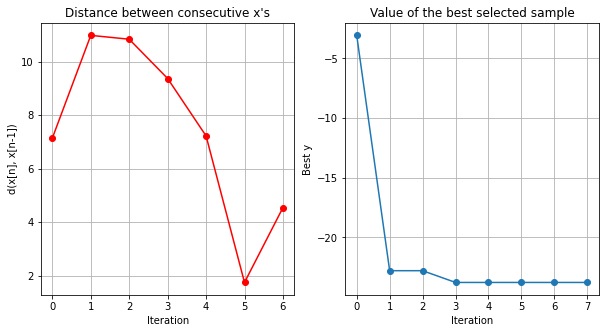

In [14]:
optimizer.plot_convergence()

It is also possible to display the values evaluated in all iterations

TypeError: _AxesBase._process_unit_info() got an unexpected keyword argument 'xdata'

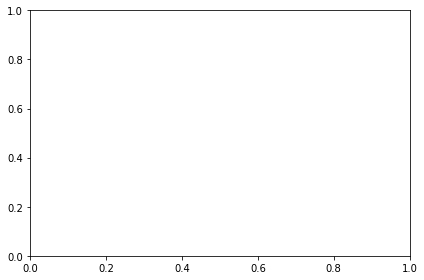

In [15]:
optimizer.plot_acquisition()

## Exercise 2

  Implement a BO optimizer for the function Rastrigin defined below. 
  
  - Use the RBF kernel https://gpy.readthedocs.io/en/deploy/GPy.kern.src.html#module-GPy.kern.src.rbf
  - Find the minimum the function in the interval [-5.12,5.12]
  - Use as stop criterion a maximum of 15 evaluations
  - Plot the performance of the algorithm and the acquisition function (MPI)
  


In [26]:
def Rastrigin_1d(x):   
    val = 10 + (x**2 - 10*np.cos(2*np.pi*x)) 
    return val

# Bounds of the function
bounds = [{'name': 'x_1', 'type': 'continuous', 'domain': (-5.12,5.12)}]

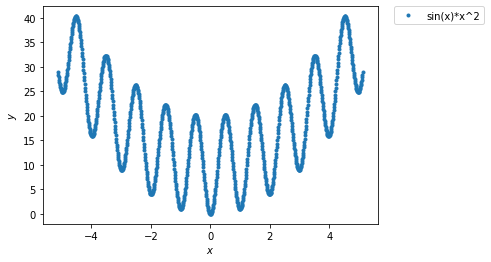

In [29]:
# We visualize the function that is going to be optimized
number_points = 1000
X = np.linspace(-5.12,5.12, number_points)
y = Rastrigin_1d(X)
plt.plot(X, y,'.',label='sin(x)*x^2')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [30]:
# We use the RBF kernel 
kernel = GPy.kern.RBF(input_dim=1,lengthscale=0.1)
optimizer = BayesianOptimization(f=Rastrigin_1d, 
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 initial_design_numdata=5,
                                 acquisition_type ='EI')

max_iter = 15     # (Number of allowed evaluations)
optimizer.run_optimization(max_iter=max_iter)

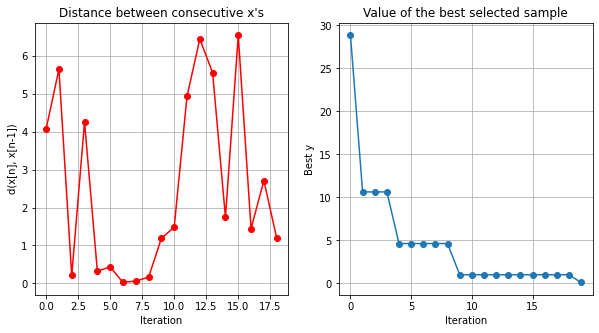

In [31]:
optimizer.plot_convergence()

## Solving a two dimensional function with BO 

GPyOpt also contains a number of functions that can be used to illustrate the way the algorithm works. In the example below, the Rosenbrock 2-dimensional function is optimized using BO. 

Analyze the example.

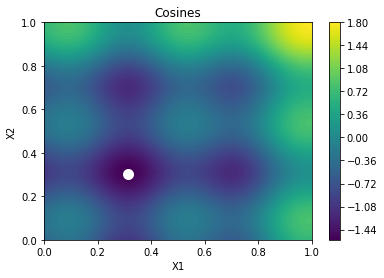

In [32]:
# Definition of the Rosenbrock function
# You can check the shape of the Beale function here: 
# https://en.wikipedia.org/wiki/Test_functions_for_optimization

objective_function  = GPyOpt.objective_examples.experiments2d.cosines() 
objective_function.plot()

We define the bounds and decide to use the squared-exponential kernel  (RBF)

In [33]:
bounds = [{'name': 'x_1', 'type': 'continuous', 'domain': (0,1)},
          {'name': 'x_2', 'type': 'continuous', 'domain': (0,1)}
         ]

kern  = GPy.kern.RBF(input_dim=2, variance=0, lengthscale=1.0)

optimizer_2d = BayesianOptimization(f=objective_function.f, 
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kern,
                                 acquisition_type ='EI')

In [34]:
max_iter = 10     # (Number of allowed evaluations)

optimizer_2d.run_optimization(max_iter=max_iter)

In [35]:
print("Best found solution ", optimizer_2d.x_opt)
print("Best value ", optimizer_2d.fx_opt)

Best found solution  [0.34748881 0.31358584]
Best value  -1.5560252812254307


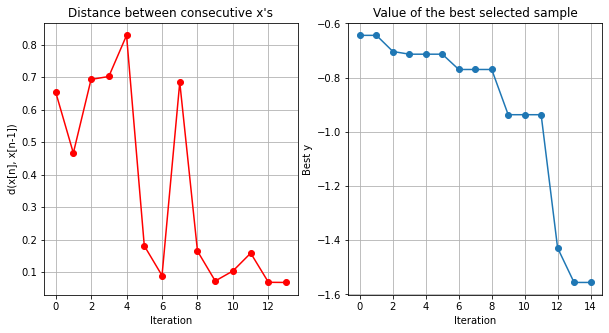

In [36]:
optimizer_2d.plot_convergence()

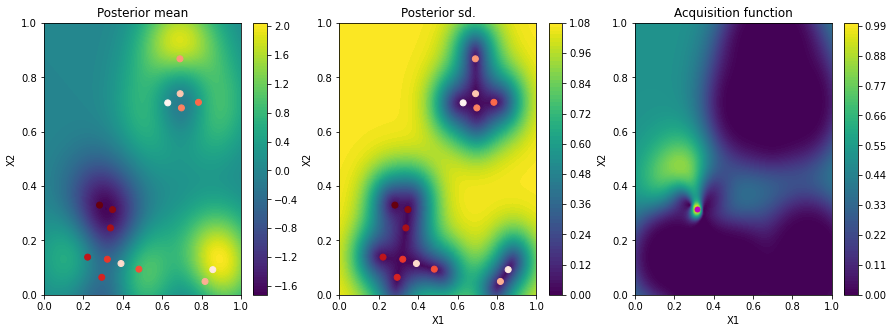

In [37]:
optimizer_2d.plot_acquisition()

GPy allows to define a variety of more flexible scenarios by adding other parameters, for example:
    
    - 'initial_design_type'        :Type of initial design: - ‘random’, to collect points in random locations. - ‘latin’, to collect points in a Latin hypercube (discrete variables are sampled randomly.)
    - 'initial_design_type'        :Number of initial points that are collected jointly before start running the optimization.
    - 'acquisition_optimizer_type' :Type of acquisition function optimization to use. - ‘lbfgs’: L-BFGS. - ‘DIRECT’: Dividing Rectangles. - ‘CMA’: covariance matrix adaptation.
    - 'model_update_interval'      :Interval of collected observations after which the model is updated (default, 1)
    
    

## Exercise 3

  Implement a BO optimizer for the 2 dimensional Mccormick function which is included as part of GPyOpt 
  
  - Optimize the function in the interval [-4,4] for all variables
  - Use as stop criterion a maximum of 20 iterations
  - Plot the performance of the algorithm and the acquisition function (MPI)
  


In [ ]:
# You can check the shape of the Mccormick function here: 
# https://en.wikipedia.org/wiki/Test_functions_for_optimization
# Notice that the color scale in the following visualization does not 
# agree with the values of the function

my_objective_function  = GPyOpt.objective_examples.experiments2d.mccormick() 
my_objective_function.plot()

## Exercise 4

 Implement a BO optimizer for the Rastrigin function in three dimensions as described in https://www.sfu.ca/~ssurjano/rastr.html
  
  - Optimize the function in the interval [-2pi,2pi] for all variables  
  - Plot the performance of the algorithm and the acquisition function 
  


##  Exercise 5 

The following function implements the evaluation of the accumulated utility of a Markov Process with two actions and two states. The two transition matrices of the Markov process are given as inputs to the function.


- Complete the XXX lines in the code of the function to run a FiniteHorizon dynamic programming solution to the problem. Notice that the number of stages for the horizon is 3.

- Implement a Bayesian optimization model (mmy_optimizer_4d) that finds the transition matrices that produces the maximum accumulated utility of all the states. 

In [43]:
# Maximization problem gpyopt
# https://github.com/SheffieldML/GPyOpt/issues/180

def Markov_Process_Function(x):
    
    print(x.shape)
    print(x)
    # Transition probabilities are extracted from the vector
    p_a1_s1_s1 = x[0,0]
    p_a1_s2_s2 = x[0,1]
    
    p_a2_s1_s1 = x[0,2]
    p_a2_s2_s2 = x[0,3]

    
    # Transition matrix for action 1 XXX
    P1 = np.array([
        [p_a1_s1_s1, 1-p_a1_s1_s1],
        [1-p_a1_s2_s2,p_a1_s2_s2]
    ])
    
    # Transition matrix for action 2 XXX
    P2 = np.array([
        [p_a2_s1_s1, 1-p_a2_s1_s1],
        [1-p_a2_s2_s2,p_a2_s2_s2]
    ])
    
    
    # Reward matrix for action 1
    R1 = np.array([[6,5],[5,6]])
    
    # Reward matrix for action 2
    R2 = np.array([[4,7],[7,4]])

    
    
    # Array of matrices containing all transition and reward matrices
    AllPs = np.array([P1,P2])
    AllRs = np.array([R1,R2])
    
    
    number_stages = 3   # XXX
    discount = 1        # XXX
    
    # Compute the optimal expected utility in each stage (and so defining the optimal policy)
    fh = mdptoolbox.mdp.FiniteHorizon(transitions=AllPs, reward=AllRs, discount=discount, N=number_stages)
    fh.run() # We run the algorithm
    Vs_per_Stages = fh.V 
    
    print(Vs_per_Stages)
    tot_Vs = np.sum(Vs_per_Stages[:,0])
    
    return tot_Vs


In [48]:
bound = [
    {'name': 'x_1', 'type': 'continuous', 'domain': (0,1)},
    {'name': 'x_2', 'type': 'continuous', 'domain': (0,1)},
    {'name': 'x_3', 'type': 'continuous', 'domain': (0,1)},
    {'name': 'x_4', 'type': 'continuous', 'domain': (0,1)}
]

kernel =  GPy.kern.RBF(input_dim=4, variance=0, lengthscale=1.0)
mmy_optimizer_4d = BayesianOptimization(f=Markov_Process_Function, 
                                 domain=bound,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='MPI')

max_iter = 10     # (Number of allowed evaluations)
mmy_optimizer_4d.run_optimization(max_iter=max_iter)
print("Best found solution ", mmy_optimizer_4d.x_opt)
print("Best value ", mmy_optimizer_4d.fx_opt)

(1, 4)
[[0.64177592 0.5421544  0.38790271 0.35250649]]
[[17.62199836 11.73758153  5.83629187  0.        ]
 [17.70777718 11.81620458  5.94248052  0.        ]]
(1, 4)
[[0.93196882 0.41171633 0.98891235 0.52372585]]
[[17.71451922 11.82970801  5.93196882  0.        ]
 [16.95603228 11.13653157  5.42882245  0.        ]]
(1, 4)
[[0.5205207  0.32874701 0.9157673  0.10195054]]
[[17.47457562 11.60377157  5.5205207   0.        ]
 [18.37239986 12.33432105  6.69414837  0.        ]]
(1, 4)
[[0.66466452 0.1219116  0.28936607 0.34060749]]
[[18.21764432 12.1545619   6.13190178  0.        ]
 [18.09975425 12.05771968  5.97817753  0.        ]]
(1, 4)
[[0.29830865 0.5219903  0.20755327 0.14139133]]
[[19.34419528 12.9119698   6.37734018  0.        ]
 [19.49758865 12.98123036  6.575826    0.        ]]
(1, 4)
[[0.92442143 0.41704867 0.98549529 0.52343335]]
[[17.68475974 11.81145251  5.92442143  0.        ]
 [16.94644893 11.13514716  5.42969995  0.        ]]
(1, 4)
[[0.91392089 0.42449456 0.98070501 0.5230028 

In [49]:
val = Markov_Process_Function(mmy_optimizer_4d.x_opt.reshape(1,4))
val

(1, 4)
[[0.53423907 0.4944154  1.         0.648318  ]]
[[16.5650891  11.04992983  5.53423907  0.        ]
 [16.5240916  11.00896503  5.4944154   0.        ]]


33.089180698282284

## Bayesian Optimization for optimizing ML algorithms 

BO is extensively applied to optimize the hyper-parameters of ML algorithms. In the example below, we use BO to optimize the hyperparameters of a regression method (Support Vector Machine for regression).

SVR has three parameters that influence its behavior:

- gamma :  Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’)
- C     :  Penalty parameter C of the error term.
- epsilon : No penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.

Usually, the SVR learning algorithm is applied with default values of the hyperparameters. In the example below we compare hyperparameters by default with those optimize using BO



The regression problem to solve is predicting the Boston house-price data from a set of parameters that describes the houses. More information about the problem can be found here: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html


In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.DESCR)


The data is split between two sets: Train and Test.  

In [ ]:
from sklearn.model_selection import train_test_split

X = boston.data
Y = boston.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

We compute first the quality of the SVR model, in terms of the MSE metric, when the default values of the hyperparameters are used:

In [ ]:
from sklearn import svm
svr = svm.SVR()
svr.fit(X_train,Y_train)
Y_train_pred = svr.predict(X_train)
Y_test_pred = svr.predict(X_test)

train_mse_score = sklearn.metrics.mean_squared_error(Y_train,Y_train_pred)
test_mse_score = sklearn.metrics.mean_squared_error(Y_test,Y_test_pred)

print('Train MSE score', train_mse_score)
print('Test MSE score', test_mse_score)
print("The default parameters obtained: C="+str(svr.C)+", epilson="+str(svr.epsilon)+", gamma="+str(svr.gamma))

Now we define the function that will be optimized by BO. It receives as input the SVR parameters and, using cross-validation on the train dataset, estimates the error MSE corresponding to using these parameters.

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def SVM_regression_function(x):    
    svr = svm.SVR(C=x[0,0], epsilon=x[0,1],gamma=x[0,2])
    scores = cross_val_score(svr, X_train,Y_train, cv=5, scoring='neg_mean_squared_error')
    mean_msq = np.mean(scores)
    print(-1*mean_msq)
    return -1.0*mean_msq


The BO model is defined. Notice that hyperparameters are expected to take values higher than 0.

In [ ]:
bounds        =[{'name': 'C',      'type': 'continuous', 'domain': (0.000001,10.)},
               {'name': 'epsilon','type': 'continuous', 'domain': (0.000001,5.)},
               {'name': 'gamma',  'type': 'continuous', 'domain': (0.000001,5.)}]

#del ml_kernel
ml_kernel  = GPy.kern.RBF(input_dim=3, variance=0, lengthscale=1.0)

ml_optimizer_3d = BayesianOptimization(f=SVM_regression_function, 
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=ml_kernel,
                                 acquisition_type ='EI')


BO is conducted 

In [ ]:
max_iter = 15  
ml_optimizer_3d.run_optimization(max_iter=max_iter)

print("Best found solution ", ml_optimizer_3d.x_opt)
print("Best value ", ml_optimizer_3d.fx_opt)



In [ ]:
ml_optimizer_3d.plot_convergence()

We evaluate the quality of the best hyper-parameters learned on the test data. Compare the error of these hyperparameters to those selected by default. 

In [ ]:
svr = svm.SVR(C=ml_optimizer_3d.x_opt[0], epsilon=ml_optimizer_3d.x_opt[1],gamma=ml_optimizer_3d.x_opt[2])
svr.fit(X_train,Y_train)
y_predict = svr.predict(X_test)
mse_score = mean_squared_error(Y_test,y_predict)
print("The error for test data after optimizing parameters is ", mse_score)